## MNIST Training and Prediction with SageMaker Chainer

[MNIST](http://yann.lecun.com/exdb/mnist/), the "Hello World" of machine learning, is a popular dataset for handwritten digit classification. It consists of 70,000 28x28 grayscale images labeled in 10 digit classes (0 to 9). This tutorial will show how to train a model to predict handwritten digits on the MNIST dataset by running a Chainer script on SageMaker using the sagemaker-python-sdk.

For more on the Chainer container, please visit the sagemaker-chainer-containers repository and the sagemaker-python-sdk repository:

* https://github.com/aws/sagemaker-chainer-containers
* https://github.com/aws/sagemaker-python-sdk

In [1]:
import sagemaker
from sagemaker import get_execution_role

sagemaker_session = sagemaker.Session()

# Get a SageMaker-compatible role used by this Notebook Instance.
role = get_execution_role()

This notebook shows how to use the SageMaker Python SDK to run your code in a local container before deploying to SageMaker's managed training or hosting environments. This can speed up iterative testing and debugging while using the same familiar Python SDK interface. Just change your estimator's train_instance_type to `local` or `local_gpu`. For more information, see [local mode](https://github.com/aws/sagemaker-python-sdk#local-mode).

In order to use this feature you'll need to install docker-compose (and nvidia-docker if training with a GPU). Running following script will install docker-compose or nvidia-docker-compose and configure the notebook environment for you.

Note, you can only run a single local notebook at one time.

In [2]:
!/bin/bash ./setup.sh

  Using cached https://files.pythonhosted.org/packages/27/3c/6fcaa3b546ae8103c444149a1746f9a7043df7503e12bad318e8217312fb/docker_compose-1.21.2-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/9d/fb/f51a03e232e00d6c504dfe815aed090c894ba3f8d3f7fd9612f3e227bf24/websocket_client-0.47.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/02/e1/2565e6b842de7945af0555167d33acfc8a615584ef7abd30d1eae00a4d80/texttable-0.9.1.tar.gz
  Using cached https://files.pythonhosted.org/packages/8d/ee/e9ecce4c32204a6738e0a5d5883d3413794d7498fe8b06f44becc028d3ba/dockerpty-0.4.1.tar.gz
  Using cached https://files.pythonhosted.org/packages/31/01/41f727a549abd788eb91d0df4c801cb4c1f5227eee04a2621e13d7ed3e04/docker-3.3.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/5c/b6/3a4ca03225f6e9a25cb47cd3c695d19b88df5928ab9310e64dec1eb3b4d1/docker_pycreds-0.2.3-py2.py3-none-any.whl
  Running setup.py bdist_wheel for texttable ... done
  St

## Download MNIST datasets

We can use Chainer's built-in get_mnist() method to download, import and preprocess the MNIST dataset.

In [3]:
import chainer

train, test = chainer.datasets.get_mnist()

/home/ec2-user/anaconda3/envs/chainer_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Parse, save, and upload the data

We save our data, then use sagemaker_session.upload_data to upload the data to an S3 location used for training. The return value identifies the S3 path to the uploaded data.

In [4]:
import os
import shutil
import numpy as np

train_images = np.array([data[0] for data in train])
train_labels = np.array([data[1] for data in train])
test_images = np.array([data[0] for data in test])
test_labels = np.array([data[1] for data in test])

try:
    os.makedirs('/tmp/data/train')
    os.makedirs('/tmp/data/test')

    np.savez('/tmp/data/train/train.npz', images=train_images, labels=train_labels)
    np.savez('/tmp/data/test/test.npz', images=test_images, labels=test_labels)

    train_input = sagemaker_session.upload_data(path=os.path.join('/tmp/data', 'train'), key_prefix='notebook/chainer/mnist')
    test_input = sagemaker_session.upload_data(path=os.path.join('/tmp/data', 'test'), key_prefix='notebook/chainer/mnist')
finally:
    shutil.rmtree('/tmp/data')

## Prepare user script for training and prediction


Writing the Chainer training script to run on Amazon SageMaker
We need to provide a training script that can run on the SageMaker platform. The training scripts are essentially the same as one you would write for local training, except that you need to provide a function train that returns a trained model.

Since we will use the same script to host the Chainer model, the script also needs a function model_fn that loads the model -- by default, Chainer models are saved to disk as model.npz. When SageMaker calls your train and model_fn functions, it will pass in arguments that describe the training environment.

While the train and model_fn functions are required, the Chainer container provides default implementations for a few other functions. The function hooks recognized by the container are listed below, with required functions in bold:

### Training
* **`train`**: This function is passed arguments read from the Training Job's environment and returns a trained model. The return value of train is saved and uploaded to S3 as a model artifact by save.

`train` can accept the following arguments by name:

* `hyperparameters (dict)`: The hyperparameters map passed from the SageMaker Python SDK.
* `channel_input_dirs (dict of str: str)`: A map of input channel names (like 'train' and 'test') to filesystem paths to data in those input channels.
* `output_data_dir (str)`: The filesystem path to write output artifacts to. Output artifacts may include checkpoints, graphs, and other files you might like to save, not including model artifacts. These artifacts are uploaded to S3 along with your model artifacts.
* `num_gpus (int)`: The number of GPUs available to the host.
* `num_cpus (int)`: The number of CPUs available to the host.
* `hosts (list of str)`: The list of hostnames for all Training Job instances.
* `current_host (str)`: The hostname of the current host.
For more on the arguments to train and others, please visit https://github.com/aws/sagemaker-containers.

* `save(model, model_dir)`: Writes the return value from train (passed in as model) to model_dir. These model artifacts are uploaded to S3 so that they can be hosted behind a SageMaker Endpoint.

The default implementation saves the model as a file named model.npz file by invoking chainer.serializers.save_npz

### Hosting and Inference
* **`model_fn(model_dir)`**: This function is invoked to load model artifacts from those written into model_dir by save.input_data
* `input_fn(input_data, content_type)`: This function is invoked to deserialize prediction data when a prediction request is made. The return value is passed to predict_fn. input_fn accepts two arguments: input_data, which is the serialized input data in the body of the prediction request, and content_type, the MIME type of the data.

The default implementation deserializes npy-formatted data into a NumPy array with content type 'application/x-npy', but the default handler can also handle CSV data with content type 'text/csv' and JSON data with content type 'application/json'

`input_fn` accepts the following arguments:

* `input_data`: serialized input data in the body of the prediction request.
* `content_type`: MIME type of the data. By default, the Chainer predictor sends prediction requests with content type 'application/x-npy'.
* `predict_fn(input_data, model)`: This function accepts the return value of input_fn (as input_data) and the return value of model_fn, model, and returns inferences obtained from the model.

The default implementation calls model(input_data) and returns the result as a NumPy array.

* `output_fn(prediction, accept)`: This function is invoked to serialize the return value from predict_fn, passed in via prediction, back to the SageMaker client in response to prediction requests

The default implementation serializes NumPy arrays returned by predict_fn, which the SageMaker Python SDK can deserialize back into a NumPy array, but the default handler can also respond with JSON or CSV, depending on the accept MIME type given in the prediction request.

Check the script below, which uses chainer to train on any number of GPUs on a single machine, to see how this works. This script implements train, and model_fn, but relies on the default save, input_fn, predict_fn, output_fn.

For more on implementing these functions, see the documentation at https://github.com/aws/sagemaker-python-sdk.

For more on the functions provided by the Chainer container, see https://github.com/aws/sagemaker-chainer-containers

See the script below, which uses chainer to train on any number of GPUs on a single machine, to see how this works. For more on implementing these functions, see the documentation at https://github.com/aws/sagemaker-python-sdk.

The below user script used in our tutorial is adapted from [chainer mnist example](https://github.com/chainer/chainer/blob/master/examples/mnist/train_mnist_data_parallel.py)

In [5]:
!cat 'chainer_mnist_single_machine.py'

#  Copyright 2018 Amazon.com, Inc. or its affiliates. All Rights Reserved.
#  
#  Licensed under the Apache License, Version 2.0 (the "License").
#  You may not use this file except in compliance with the License.
#  A copy of the License is located at
#  
#      http://www.apache.org/licenses/LICENSE-2.0
#  
#  or in the "license" file accompanying this file. This file is distributed 
#  on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either 
#  express or implied. See the License for the specific language governing 
#  permissions and limitations under the License.

from __future__ import print_function

import os

import numpy as np
import chainer
import chainer.functions as F
import chainer.links as L
from chainer import training, serializers
from chainer.training import extensions
from chainer.datasets import tuple_dataset


# Define the network to train MNIST
class MLP(chainer.Chain):
    def __init__(self, n_units, n_out):
        super(MLP, self).__init__()
 

## Create SageMaker chainer estimator

To train MNIST, let's construct a `sagemaker.chainer.estimator.Chainer` estimator. A quick explanation for some configurable arguments here:

`entry_point`: The user script SageMaker runs for training and prediction.

`train_instance_count`: The number of SageMaker instances for training. Since we only do single machine training in this tutorial, it should be 1.

`train_instance_type`: The type of SageMaker instances for training. We pass the string `local` or `local_gpu` here to enable the local mode for training in the local environment. `local` is for cpu training and `local_gpu` is for gpu training. If you want to train on a remote instance, specify a SageMaker ML instance type here accordingly. See [Amazon SageMaker ML Instance Types](https://aws.amazon.com/sagemaker/pricing/instance-types/)

`hyperparameters`: The hyper-parameters defined in the user script. In this tutorial, `epochs`, `batch_size` and `frequency` can be configured and passed.

In [6]:
import subprocess

from sagemaker.chainer.estimator import Chainer

instance_type = 'local'

if subprocess.call('nvidia-smi') == 0:
    ## Set type to GPU if one is present
    instance_type = 'local_gpu'
    
print("Instance type = " + instance_type)

chainer_estimator = Chainer(entry_point='chainer_mnist_single_machine.py', role=role,
                            train_instance_count=1, train_instance_type=instance_type,
                            hyperparameters={'epochs': 16, 'batch_size': 128})

Instance type = local


## Train on MNIST data in S3

After we've constructed our Chainer object, we can fit it using the MNIST data we uploaded to S3. SageMaker makes sure our data is available in the local filesystem, so our user script can simply read the data from disk.

In [7]:
chainer_estimator.fit({'train': train_input, 'test': test_input})

INFO:sagemaker:Creating training-job with name: sagemaker-chainer-2018-05-18-19-20-19-490


Attaching to tmp_b4m6t_f_algo-1-5NVV4_1
algo-1-5NVV4_1  | 2018-05-18 19:20:28,055 INFO - root - running container entrypoint
algo-1-5NVV4_1  | 2018-05-18 19:20:28,057 INFO - root - starting train task
algo-1-5NVV4_1  | 2018-05-18 19:20:28,059 INFO - container_support.app - started training: {'train_fn': <function train at 0x7f57f6760d08>}
algo-1-5NVV4_1  | Downloading s3://sagemaker-us-west-2-142577830533/sagemaker-chainer-2018-05-18-19-20-19-490/source/sourcedir.tar.gz to /tmp/script.tar.gz
algo-1-5NVV4_1  | 2018-05-18 19:20:28,077 INFO - botocore.vendored.requests.packages.urllib3.connectionpool - Starting new HTTP connection (1): 169.254.169.254
algo-1-5NVV4_1  | 2018-05-18 19:20:28,083 INFO - botocore.vendored.requests.packages.urllib3.connectionpool - Starting new HTTP connection (1): 169.254.169.254
algo-1-5NVV4_1  | 2018-05-18 19:20:28,125 INFO - botocore.vendored.requests.packages.urllib3.connectionpool - Starting new HTTPS connection (1): sagemaker-us-west-2-142577830533.s3.am

tmp_b4m6t_f_algo-1-5NVV4_1 exited with code 0
Aborting on container exit...
===== Job Complete =====


Our user script writes various artifacts, such as plots, to a directory `output_data_dir`, the contents of which SageMaker uploads to S3. Now we download and extract these artifacts.

In [8]:
try:
    os.makedirs('output/single_machine_mnist')
except OSError:
    print('Directory already exist!')

chainer_training_job = chainer_estimator.latest_training_job.name

desc = chainer_estimator.sagemaker_session.sagemaker_client.describe_training_job(TrainingJobName=chainer_training_job)
output_data = desc['ModelArtifacts']['S3ModelArtifacts'].replace('model', 'output')
status = os.system('cp {}/data/*.png output/single_machine_mnist'.format(output_data))

These plots show the accuracy and loss over epochs:

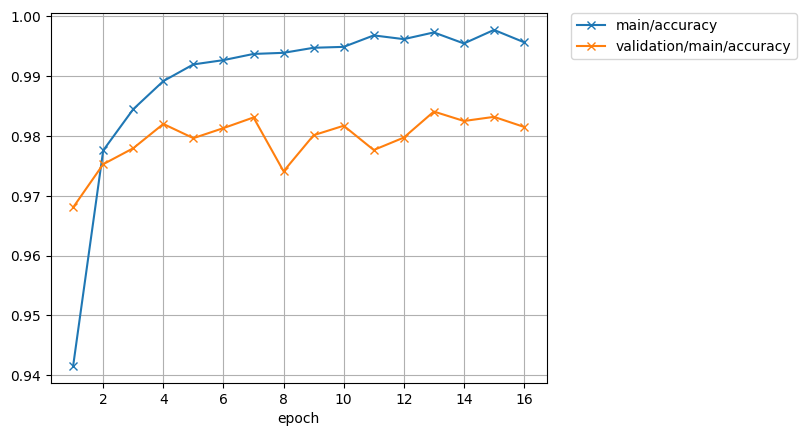

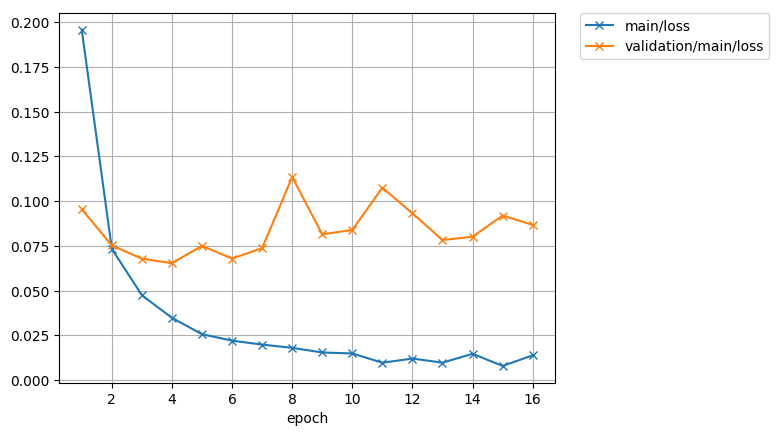

In [9]:
from IPython.display import Image
from IPython.display import display

accuracy_graph = Image(filename = "output/single_machine_mnist/accuracy.png", width=800, height=800)
loss_graph = Image(filename = "output/single_machine_mnist/loss.png", width=800, height=800)

display(accuracy_graph, loss_graph)

## Deploy model to endpoint

After training, we deploy the model to an endpoint using the Chainer estimator object. Here we also specify instance_type to be `local` or `local_gpu` to deploy the model to the local environment. If you want to deploy the model to a remote instance, specify a SageMaker ML instance type here accordingly. But note that if you train in local mode, you have to deploy in local mode as well. For now SageMaker does not support training in local mode and deploying to remote instance.

In [10]:
predictor = chainer_estimator.deploy(initial_instance_count=1, instance_type=instance_type)

INFO:sagemaker:Creating model with name: sagemaker-chainer-2018-05-18-19-20-19-490
INFO:sagemaker:Creating endpoint with name sagemaker-chainer-2018-05-18-19-20-19-490


!

## Predict Hand-Written Digit

We can now use this predictor to classify hand-written digits. Let's get some random test images in MNIST first.

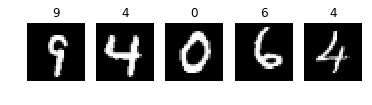

In [33]:
import random

import matplotlib.pyplot as plt

num_samples = 5
indices = random.sample(range(test_images.shape[0] - 1), num_samples)
images, labels = test_images[indices], test_labels[indices]

for i in range(num_samples):
    plt.subplot(1,num_samples,i+1)
    plt.imshow(images[i].reshape(28, 28), cmap='gray')
    plt.title(labels[i])
    plt.axis('off')

Now let's see if we can make correct predictions.

In [34]:
prediction = predictor.predict(images)
predicted_label = prediction.argmax(axis=1)
print('The predicted labels are: {}'.format(predicted_label))

The predicted labels are: [9 4 0 6 4]


Now let's get some test data from you! Drawing into the image box loads the pixel data into a variable named 'data' in this notebook, which we can then pass to the Chainer predictor.

In [17]:
from IPython.display import HTML
HTML(open("input.html").read())

Now let's see if your writing can be recognized!

In [28]:
image = np.array(data, dtype=np.float32)
prediction = predictor.predict(image)
predicted_label = prediction.argmax(axis=1)[0]
print('What you wrote is: {}'.format(predicted_label))

What you wrote is: 7


## Clean resources

After you have finished with this example, remember to delete the prediction endpoint to release the instance associated with it and remove the outputs saved locally.

In [35]:
chainer_estimator.delete_endpoint()
shutil.rmtree('output')

INFO:sagemaker:Deleting endpoint with name: sagemaker-chainer-2018-05-18-19-20-19-490
